In [ ]:
# default_exp metrics

In [ ]:
# hide
# missing
!git clone https://github.com/marcomatteo/steel_segmentation.git

In [ ]:
# hide
# missing
!pip install -e steel_segmentation

# Metrics

> A collection of Metrics used in the segmentation models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/dev_nbs/05_metrics.ipynb)

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
from steel_segmentation.metadata import *
from steel_segmentation.masks import *
from steel_segmentation.datasets import *
from steel_segmentation.dataloaders import *

import fastai
from fastai.vision.all import *
from fastcore.foundation import *

## Metrics for fastai API

Some code from the fastai docs to test properly the metrics:

In [ ]:
#For testing: a fake learner and a metric that isn't an average
@delegates()
class TstLearner(Learner):
    def __init__(self,dls=None,model=None,**kwargs): self.pred,self.xb,self.yb = None,None,None
        
#Go through a fake cycle with various batch sizes and computes the value of met
def compute_val(met, x1, x2):
    met.reset()
    vals = [0,6,15,20]
    learn = TstLearner()
    for i in range(3):
        learn.pred,learn.yb = x1[vals[i]:vals[i+1]], (x2[vals[i]:vals[i+1]],)
        met.accumulate(learn)
    return met.value

In [ ]:
# export
class ModDiceMulti(Metric):
    "Averaged Dice metric (Macro F1) for multiclass target in segmentation"

    def __init__(self, axis=1): self.axis = axis
    def reset(self): self.inter, self.union = {}, {}

    def accumulate(self, learn):
        pred = learn.pred.argmax(dim=self.axis)
        y = learn.yb[0]
        
        if pred.shape != y.shape:
            y = y.argmax(dim=self.axis)
            
        pred, targ = flatten_check(pred, y)
        for c in range(learn.pred.shape[self.axis]):
            p = torch.where(pred == c, 1, 0)
            t = torch.where(targ == c, 1, 0)
            p, t = TensorBase(p), TensorBase(t)
            c_inter = (p*t).float().sum().item()
            c_union = (p+t).float().sum().item()
            if c in self.inter:
                self.inter[c] += c_inter
                self.union[c] += c_union
            else:
                self.inter[c] = c_inter
                self.union[c] = c_union

    @property
    def value(self):
        binary_dice_scores = np.array([])
        for c in self.inter:
            binary_dice_scores = np.append(
                binary_dice_scores, 2.*self.inter[c]/self.union[c] if self.union[c] > 0 else np.nan)
        return np.nanmean(binary_dice_scores)

For test purpose, we create a tensor, `x1`, as a prediction for the first channel.

In [ ]:
x1a = torch.ones(20,1,1,1)
x1b = torch.clone(x1a)*0.5
x1c = torch.clone(x1a)*0.3
x1d = torch.clone(x1a)*0.1

x1 = torch.cat((x1a,x1b,x1c,x1d),dim=1)   # Prediction: 20x4
x1.shape

torch.Size([20, 4, 1, 1])

The target is a flatten mask, used by fastai segmentation models.

In [ ]:
x2 = torch.zeros(20,1,1)  # Target: 20xClass0
x2[0:5], x2.shape

(tensor([[[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]],
 
         [[0.]]]),
 torch.Size([20, 1, 1]))

In [ ]:
dice_obj = DiceMulti()

Test of `DiceMulti` into a simulated training with `compute_val` and a test Learner with `TstLearner`.

In [ ]:
# Dice metric = 1
test_eq(compute_val(dice_obj, x1, x2), 1.)

In [ ]:
x2 = torch.ones(20,1,1)  # Target: 20xClass1
# Dice metric = 0
test_eq(compute_val(dice_obj, x1, x2), 0.)

Different scenario with a multiclass batch:
- Class0 x 10
- Class1 x 4
- Class2 x 3
- Class4 x 3

In [ ]:
x2a = torch.zeros(10,1,1)
x2b = torch.ones(4,1,1)
x2c = torch.ones(3,1,1) * 2
x2d = torch.ones(3,1,1) * 3

x2 = torch.cat((x2a,x2b,x2c,x2d),dim=0)   # Target: 10xClass0, 4xClass1, 3xClass2, 3xClass4
x2.shape

torch.Size([20, 1, 1])

In [ ]:
dice1 = (2*10)/(2*10+4+3+3)              # Dice: 2*TP/(2*TP+FP+FN)
dice2 = 0
dice3 = 0
dice4 = 0
# Value to be tested
computed_dice = compute_val(dice_obj, x1, x2)
# Dice metric = 0.1666
test_eq(computed_dice, (dice1+dice2+dice3+dice4)/4)
print(f"[{[dice1, dice2, dice3, dice4]}]")
print(computed_dice)

[[0.6666666666666666, 0, 0, 0]]
0.16666666666666666


In [ ]:
dice_obj.inter

{0: 10.0, 1: 0.0, 2: 0.0, 3: 0.0}

In [ ]:
dice_obj.union

{0: 30.0, 1: 4.0, 2: 3.0, 3: 3.0}

In [ ]:
binary_dice_scores = np.array([])
for c in dice_obj.inter:
    binary_dice_scores = np.append(
        binary_dice_scores, 
        2.*dice_obj.inter[c]/dice_obj.union[c] 
        if dice_obj.union[c] > 0 else np.nan)

In [ ]:
binary_dice_scores

array([0.66666667, 0.        , 0.        , 0.        ])

In [ ]:
np.nanmean(binary_dice_scores)

0.16666666666666666

In [ ]:
# export
class KaggleDice(Metric):
    def __init__(self, axis=1, eps=1e-9): self.axis, self.eps = axis, eps
    def reset(self): self.inter, self.union = {}, {}
    
    def accumulate(self, learn):
        y = learn.yb[0]
        preds = learn.pred
        
        n, c = y.shape[0], preds.shape[self.axis]
        
        pred = preds.argmax(dim=self.axis).view(n, -1)
        targs = y.view(n, -1)
        
        pred, targ = flatten_check(pred, targs)
        for i in range(0, c):
            p = torch.where(pred == i, 1, 0)
            t = torch.where(targs == i, 1, 0)
            c_inter = (p*t).sum(-1).float()#.item()
            c_union = (p+t).sum(-1).float()#.item()
            if i in self.inter:
                self.inter[i] = torch.cat([self.inter[i], c_inter], dim=0)
                self.union[i] = torch.cat([self.union[i], c_union], dim=0)
            else:
                self.inter[i] = c_inter
                self.union[i] = c_union
    
    @property
    def value(self):
        binary_dice_scores = np.array([])
        for c in range(len(self.inter)):
            cond = self.union[c] == 0
            val = 2.*(self.inter[c]+self.eps)/(self.union[c]+self.eps)
            val[cond] = 1
            binary_dice_scores = np.append(binary_dice_scores, val)
        return np.nanmean(binary_dice_scores)

The competition "Evaluation" metric is defined as:

> This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:

$$
J(A,B) = \frac{2 * |A \cap B|}{|A| \cup |B|}
$$

> where X is the predicted set of pixels and Y is the ground truth. The Dice coefficient is defined to be 1 when both X and Y are empty. The leaderboard score is the mean of the Dice coefficients for each <ImageId, ClassId> pair in the test set.

In [ ]:
dice_kaggle_obj = KaggleDice()

In [ ]:
computed_kaggle_dice = compute_val(dice_kaggle_obj, x1, x2)

In [ ]:
dice_kaggle_obj.value

0.7500000000777778

Test for `KaggleDice`:

In [ ]:
vals = [0,6,15,20]
intersect, union = {}, {}

In [ ]:
for i in range(3):
    pred = x1[vals[i]:vals[i+1]].clone()
    targs = (x2[vals[i]:vals[i+1]].clone(),)
    eps = 1e-9

    #pred[0]

    n, c = targs[0].shape[0], pred.shape[1]
    #n, c

    pred = pred.argmax(dim=1).view(n, -1)
    targs = targs[0].view(n, -1)
    #pred.shape, targs.shape

    #pred[0]

    for i in range(0, c):
        p = torch.where(pred == i, 1, 0)
        t = torch.where(targs == i, 1, 0)
        #p, t = TensorBase(p), TensorBase(t)
        c_inter = (p*t).sum(-1).float()#.item()
        c_union = (p+t).sum(-1).float()#.item()
        if i in intersect:
            intersect[i] = torch.cat([intersect[i], c_inter], dim=0)
            union[i] = torch.cat([union[i], c_union], dim=0)
        else:
            intersect[i] = c_inter
            union[i] = c_union

        #print(f"Iter n.{i}\nintersect: {intersect[i]}\nunion: {union[i]}", end="\n\n")

In [ ]:
intersect

{0: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 1: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 2: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 3: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [ ]:
union

{0: tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]),
 1: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
         0., 0.]),
 2: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
         0., 0.]),
 3: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1.])}

In [ ]:
binary_dice_scores = np.array([])
for c in intersect.keys():
    cond = union[c] == 0
    val = 2.*(intersect[c]+eps)/(union[c]+eps)
    val[cond] = 1
    binary_dice_scores = np.append(binary_dice_scores, val)

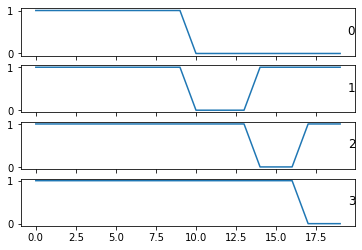

In [ ]:
num = 4
fig, axs = plt.subplots(num, 1, sharex=True)
for i in range(num):
    axs[i].plot(binary_dice_scores[(i*20):((i*20)+20)])
    axs[i].set_title(i, loc='right', y=.6, pad=-7.)

In [ ]:
test_close(computed_kaggle_dice, binary_dice_scores.mean())

In [ ]:
# export
def dice_kaggle(
    preds: Tensor, 
    targs: Tensor, 
    iou: bool = False, 
    eps: float = 1e-8
):
    """
    The metric of the competition, 
    if there's no defect in `targs` and no defects in `preds`: dice=1.
    """
    n, c = targs.shape[0], preds.shape[1]
    preds = preds.argmax(dim=1).view(n, -1)
    targs = targs.view(n, -1)

    intersect_list, union_list = [], []
    for i in range(c):
        inp, trgs = TensorBase(preds), TensorBase(targs)
        
        inter = ((inp == i) & (trgs == i)).sum(-1).float()
        un = ((inp == i).sum(-1) + (trgs == i).sum(-1))
        
        intersect_list.append(inter)
        union_list.append(un)

    intersect = torch.stack(intersect_list)
    union = torch.stack(union_list)

    if not iou:
        dice = ((2.0 * intersect + eps) / (union + eps))
        return dice.mean()
    else:
        int_over_union = ((intersect + eps) / (union - intersect + eps)).mean()

In [ ]:
dice_kag = dice_kaggle(x1, x2)
dice_kag

TensorBase(0.7500)

In [ ]:
test_ne(computed_dice, dice_kag)

In [ ]:
# export
fastai_dice_metrics = [ModDiceMulti()]

## Intersection Over Union

In [ ]:
#export
def iou(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
    activation: str = "Sigmoid"
):
    """
    https://github.com/catalyst-team/catalyst/blob/master/catalyst/dl/utils/criterion/iou.py
    Args:
        outputs (torch.Tensor): A list of predicted elements
        targets (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold (float): threshold for outputs binarization
        activation (str): An torch.nn activation applied to the outputs.
            Must be one of ["none", "Sigmoid", "Softmax2d"]
    Returns:
        float: IoU (Jaccard) score
    """
    outputs = F.sigmoid(outputs)

    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    iou = intersection / (union - intersection + eps)

    return iou

In [ ]:
#export
def iou_binary_metric(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = mean(ious)    # mean accross images if per_image
    return 100 * iou

In [ ]:
#export
def iou_metric(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []    
        for i in range(C):
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / float(union))
        ious.append(iou)
    ious = [np.mean(iou) for iou in zip(*ious)] # mean accross images if per_image
    return 100 * np.array(ious)

In [ ]:
# export
def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    """computes IoU for one ground truth mask and predicted mask"""
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
        else:
            ious.append(1)
    return ious if ious else [1]

In [ ]:
x3 = torch.zeros(20,4,1,1)
for i in range(4):
    x3[:, i, :, :] = torch.where(x2 == i, 1, 0)

In [ ]:
compute_ious(x1[:, 0].numpy(), x3[:, 0].numpy(), classes=[0,1,2,3], only_present=False)

[0.0, 0.5, 1, 1]

In [ ]:
for i in range(4):
    print(compute_ious(x1[:, i].numpy(), x3[:, i].numpy(), classes=[0,1,2,3], only_present=False))

[0.0, 0.5, 1, 1]
[0.0, 0.0, 1, 1]
[0.0, 0.0, 1, 1]
[0.0, 0.0, 1, 1]


In [ ]:
# export
def compute_iou_batch(outputs, labels, classes=None):
    """computes mean iou for a batch of ground truth masks and predicted masks"""
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

In [ ]:
compute_iou_batch(x1, x3, classes=[0,1,2,3])

0.25

## Dice

In [ ]:
#export
def dice(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None
):
    """
    Computes the binary dice metric
    Args:
        outputs (list):  A list of predicted elements
        targets (list): A list of elements that are to be predicted
        eps (float): epsilon
        threshold (float): threshold for outputs binarization
    Returns:
        double:  Dice score
    """
    outputs = F.sigmoid(outputs)

    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = 2 * intersection / (union + eps)

    return dice

Here there'are some functions used by the pure pytorch solution from a kaggle kernel.

In [ ]:
# export
def metric(probability, truth, threshold=0.5, reduction='none'):
    """
    Calculates dice of positive and negative images seperately
    `probability` and `truth` must be `torch.Tensors`.
    """
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

In [ ]:
metric(x1, x3)[0]

In [ ]:
#export
def predict(X, threshold):
    """X is sigmoid output of the model"""
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

In [ ]:
# export
class Meter:
    """A meter to keep track of iou and dice scores throughout an epoch"""
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        
        self.base_dice_scores.extend(dice.tolist())
        self.dice_pos_scores.extend(dice_pos.tolist())
        self.dice_neg_scores.extend(dice_neg.tolist())
        
        preds = predict(probs, self.base_threshold)
        
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        """
        Calc the mean of dices metrics (dice, dice_neg, dice_pos)
        and IoU mean.
        
        Returns: 
            `dices` as list of means `[dice, dice_neg, dice_pos]`,
            `iou` as mean of IoUs
        """
        dice     = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        
        return dices, iou

In [ ]:
show_doc(Meter.get_metrics)

In [ ]:
# export
def epoch_log(phase, epoch, epoch_loss, meter, start):
    """logging the metrics at the end of an epoch"""
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print(f"Loss: {epoch_loss:.4f} | IoU: {iou:.4f} | dice: {dice:.4f} | dice_neg: {dice_neg:.4f} | dice_pos: {dice_pos:.4f}")
    return dice, iou

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()